In [1]:
import os
import glob
import torch
import numpy as np
from skimage import io, transform
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("../src/models/")
from build import build_model

/Users/makam0a/opt/anaconda3/envs/transformer/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'torchsummary'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
model_type='unet'
problem='denoise'
prefix=''

In [4]:
model = build_model(model_type,'denoising')
#model= nn.DataParallel(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#summary(model, (1, 224, 224), device='cuda')

Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


BaseUnet(
  (unet): UNet(
    (encoder1): Sequential(
      (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu1): ReLU(inplace=True)
      (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder2): Sequential(
      (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc2relu1): ReLU(inplace=True)
      (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm2): BatchNo

In [5]:
from noiseadding import complex_noise_transforms, strong_noise_transforms
if prefix:
    noise_transforms = strong_noise_transforms
else:
    noise_transforms = complex_noise_transforms

In [6]:
from data import get_train_val_dataset, get_dataset
denoise_dataset = get_dataset(problem, noise_transforms=noise_transforms)

In [7]:
batch_size=8
workers=4
train_dataset, val_dataset = get_train_val_dataset(denoise_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
print('Dataset size (num. batches)', len(train_loader), len(valid_loader))

Dataset size (num. batches) 239 27


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


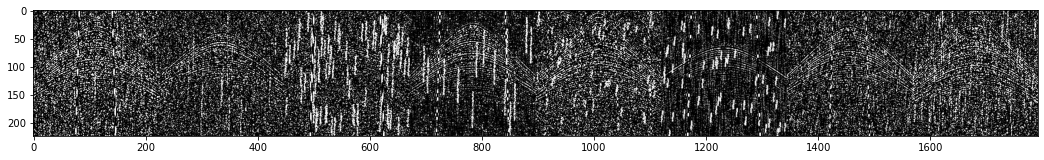

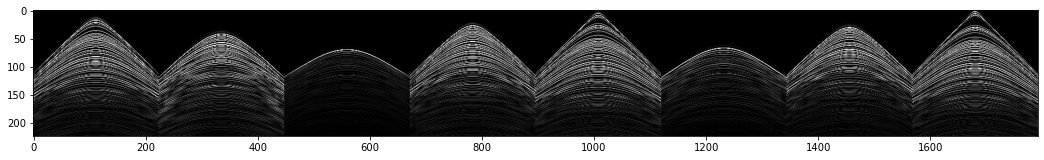

In [8]:
# Examine training data
%pylab inline
import torchvision
sample = iter(train_loader).next()
figure(figsize=(18,9))
imshow(torchvision.utils.make_grid(sample['input'], padding=0).permute((1, 2, 0)))
figure(figsize=(18,9))
imshow(torchvision.utils.make_grid(sample['target'].float(), padding=0).permute((1, 2, 0)))
#sample['target']

In [11]:
loss_fn = nn.MSELoss()

In [13]:
METADATA = '../metadata/'

epochs = 30
learning_rate = 5e-5

run_id = prefix + 'denoise_model_{}_problem_{}_gpu_n{}_bs{}_lr{}_pretrained'.format(model_type, problem, epochs, batch_size, learning_rate); print('\n\nTraining', run_id)
save_path = os.path.join(METADATA, run_id + '.pkl')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



Training denoise_model_unet_problem_denoise_gpu_n30_bs8_lr5e-05_pretrained


In [13]:
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

class RMSE(object):
    def __init__(self):
        self.sq_errors = []
        self.num_pix = 0
        
    def get(self):
        return np.sqrt(
                    np.sum(np.array(self.sq_errors))/self.num_pix
                )
    
    def add_batch(self, pred, target):
        sqe = (pred-target)**2
        self.sq_errors.append(np.sum(sqe))
        self.num_pix += target.size
        
    def reset(self):
        self.sq_errors = []
        self.num_pix = 0


# Used to keep track of statistics
class AverageMeter(object):
    def __init__(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

REPORTS_PER_EPOCH = 10
ITER_PER_EPOCH = len(train_loader)
ITER_PER_REPORT = ITER_PER_EPOCH//REPORTS_PER_EPOCH

metrics = RMSE()

iteration_losses = []
iteration_avg_rmse = []

for epoch in range(epochs):
    model.train()
    
    # Progress reporting
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)
    end = time.time()

    for i, (sample) in enumerate(train_loader):

        # Load a batch and send it to GPU
        x = sample['input'].to(device)
        y = sample['target'].to(device)

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        
        # Record loss
        losses.update(loss.data.item(), x.size(0))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
        
        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log training progress
        if i % ITER_PER_REPORT == 0:
            print('\nEpoch: [{0}][{1}/{2}]\t' 'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t' 'ETA {eta}\t'
             'Training Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))
        elif i % (ITER_PER_REPORT//20) == 0:
            print('.', end='')
            
        #break # useful for quick debugging        
    torch.cuda.empty_cache(); del x, y; 
    
    # Validation after each epoch
    model.eval()
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['input'].float().to(device), sample['target'].numpy()
        with torch.no_grad():
            y_pred = model(x).detach().cpu().numpy()

        metrics.add_batch(y_pred, y)
        print('_', end='')
    print('\nValidation RMSE {avg_rmse}'.format(avg_rmse=metrics.get()))    
    iteration_losses.append(losses.avg)
    iteration_avg_rmse.append(metrics.get())

# Save model
save_path = os.path.join(METADATA, run_id + '.pkl')
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))



Training large_noisedenoise_model_unet_problem_denoise_gpu_n30_bs8_lr5e-05_pretrained

Epoch: [0][0/239]	Time 2.886 (2.886)	ETA 0:11:29	Training Loss 0.3598 (0.3598)
......................
Epoch: [0][23/239]	Time 0.090 (18.585)	ETA 0:00:19	Training Loss 0.3468 (0.3829)
......................
Epoch: [0][46/239]	Time 0.120 (36.419)	ETA 0:00:23	Training Loss 0.3347 (0.3743)
......................
Epoch: [0][69/239]	Time 2.632 (54.044)	ETA 0:07:27	Training Loss 0.3182 (0.3625)
......................
Epoch: [0][92/239]	Time 0.093 (69.604)	ETA 0:00:13	Training Loss 0.3179 (0.3507)
......................
Epoch: [0][115/239]	Time 0.124 (86.596)	ETA 0:00:15	Training Loss 0.3087 (0.3409)
......................
Epoch: [0][138/239]	Time 0.132 (101.347)	ETA 0:00:13	Training Loss 0.2640 (0.3300)
......................
Epoch: [0][161/239]	Time 2.206 (115.324)	ETA 0:02:52	Training Loss 0.2833 (0.3215)
......................
Epoch: [0][184/239]	Time 0.098 (128.045)	ETA 0:00:05	Training Loss 0.3033 (0

......................
Epoch: [6][207/239]	Time 0.097 (125.742)	ETA 0:00:03	Training Loss 0.1665 (0.1807)
......................
Epoch: [6][230/239]	Time 0.653 (140.313)	ETA 0:00:05	Training Loss 0.1925 (0.1804)
........___________________________
Validation RMSE 0.4254181894969538

Epoch: [7][0/239]	Time 2.755 (2.755)	ETA 0:10:58	Training Loss 0.1452 (0.1452)
......................
Epoch: [7][23/239]	Time 0.090 (15.185)	ETA 0:00:19	Training Loss 0.1496 (0.1721)
......................
Epoch: [7][46/239]	Time 0.102 (29.381)	ETA 0:00:19	Training Loss 0.1492 (0.1731)
......................
Epoch: [7][69/239]	Time 0.127 (44.099)	ETA 0:00:21	Training Loss 0.1520 (0.1744)
......................
Epoch: [7][92/239]	Time 2.032 (58.109)	ETA 0:04:58	Training Loss 0.1879 (0.1746)
......................
Epoch: [7][115/239]	Time 0.095 (70.757)	ETA 0:00:11	Training Loss 0.1497 (0.1742)
......................
Epoch: [7][138/239]	Time 0.188 (84.891)	ETA 0:00:18	Training Loss 0.1991 (0.1738)
...........

......................
Epoch: [13][161/239]	Time 0.126 (101.829)	ETA 0:00:09	Training Loss 0.1617 (0.1435)
......................
Epoch: [13][184/239]	Time 2.025 (116.304)	ETA 0:01:51	Training Loss 0.1682 (0.1437)
......................
Epoch: [13][207/239]	Time 0.090 (128.588)	ETA 0:00:02	Training Loss 0.1806 (0.1437)
......................
Epoch: [13][230/239]	Time 0.095 (143.206)	ETA 0:00:00	Training Loss 0.1236 (0.1437)
........___________________________
Validation RMSE 0.38290050430473943

Epoch: [14][0/239]	Time 3.404 (3.404)	ETA 0:13:33	Training Loss 0.1191 (0.1191)
......................
Epoch: [14][23/239]	Time 0.091 (18.246)	ETA 0:00:19	Training Loss 0.1561 (0.1386)
......................
Epoch: [14][46/239]	Time 0.115 (36.377)	ETA 0:00:22	Training Loss 0.1422 (0.1378)
......................
Epoch: [14][69/239]	Time 0.131 (53.980)	ETA 0:00:22	Training Loss 0.1388 (0.1398)
......................
Epoch: [14][92/239]	Time 2.863 (71.874)	ETA 0:07:00	Training Loss 0.1293 (0.1422)

......................
Epoch: [27][23/239]	Time 0.093 (15.770)	ETA 0:00:20	Training Loss 0.1050 (0.1069)
......................
Epoch: [27][46/239]	Time 0.115 (30.973)	ETA 0:00:22	Training Loss 0.0939 (0.1049)
......................
Epoch: [27][69/239]	Time 0.109 (45.286)	ETA 0:00:18	Training Loss 0.1188 (0.1059)
......................
Epoch: [27][92/239]	Time 2.012 (59.729)	ETA 0:04:55	Training Loss 0.1023 (0.1063)
......................
Epoch: [27][115/239]	Time 0.094 (72.643)	ETA 0:00:11	Training Loss 0.1152 (0.1066)
......................
Epoch: [27][138/239]	Time 0.532 (87.282)	ETA 0:00:53	Training Loss 0.1161 (0.1055)
......................
Epoch: [27][161/239]	Time 0.092 (102.594)	ETA 0:00:07	Training Loss 0.1207 (0.1050)
......................
Epoch: [27][184/239]	Time 0.119 (120.556)	ETA 0:00:06	Training Loss 0.0910 (0.1045)
......................
Epoch: [27][207/239]	Time 0.127 (138.404)	ETA 0:00:04	Training Loss 0.1151 (0.1044)
......................
Epoch: [27][230/239]	Tim

In [14]:
save_path = os.path.join(METADATA, run_id + '.pkl')
torch.save(model.state_dict(), save_path)

In [15]:
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [16]:
# Validation after each epoch
model.eval()
metrics.reset()
for i, (sample) in enumerate(valid_loader):
    x, y = sample['input'].float().to(device), sample['target'].numpy()
    with torch.no_grad():
        y_pred = model(x).detach().cpu().numpy()

    metrics.add_batch(y_pred, y)
    print('_', end='')
print('\nValidation RMSE {avg_rmse}'.format(avg_rmse=metrics.get()))    
iteration_losses.append(losses.avg)
iteration_avg_rmse.append(metrics.get())
#scheduler.step()

___________________________
Validation RMSE 0.32701104772148315


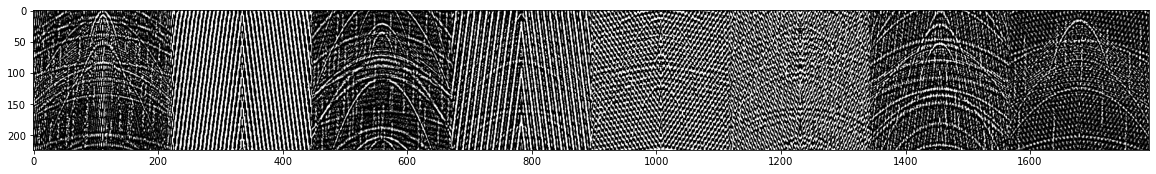

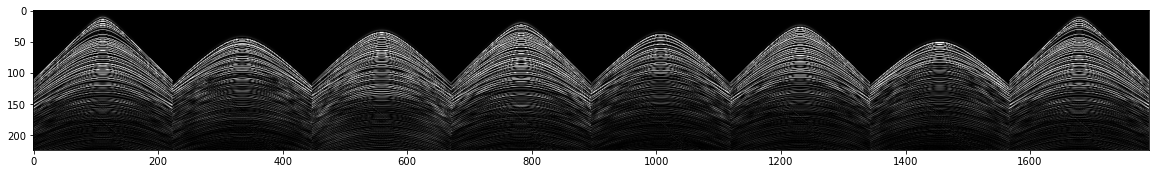

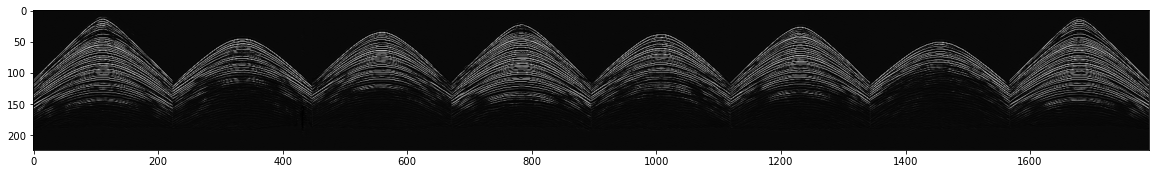

In [17]:
# Load model from disk
#model = create_model_gpu()
#model.load_state_dict(torch.load('model_gpu[0]_n10_bs8_lr0.0001.pkl'))
model.eval() # set to evaluation mode

# Visualize validation sample
sample = iter(valid_loader).next()
x = sample['input'].cuda()
y_pred, y = model(x), sample['target']

figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['input'], padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['target'], padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(y_pred.detach().cpu(), padding=0).permute((1, 2, 0)))

In [14]:
problem='firstbreak'

In [19]:
model = build_model(model_type, problem)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, (1, 224, 224), device='cuda')

Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Layer (type:depth-idx)                   Output Shape              Param #
├─UNet: 1-1                              [-1, 2, 224, 224]         --
|    └─Sequential: 2-1                   [-1, 32, 224, 224]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 224, 224]        288
|    |    └─BatchNorm2d: 3-2             [-1, 32, 224, 224]        64
|    |    └─ReLU: 3-3                    [-1, 32, 224, 224]        --
|    |    └─Conv2d: 3-4                  [-1, 32, 224, 224]        9,216
|    |    └─BatchNorm2d: 3-5             [-1, 32, 224, 224]        64
|    |    └─ReLU: 3-6                    [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-2                    [-1, 32, 112, 112]        --
|    └─Sequential: 2-3                   [-1, 64, 112, 112]        --
|    |    └─Conv2d: 3-7                  [-1, 64, 112, 112]        18,432
|    |    └─BatchNorm2d: 3-8             [-1, 64, 112, 112]        128
|    |    └─ReLU: 3-9                    [-1, 64, 112, 112]        --
|    |

Layer (type:depth-idx)                   Output Shape              Param #
├─UNet: 1-1                              [-1, 2, 224, 224]         --
|    └─Sequential: 2-1                   [-1, 32, 224, 224]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 224, 224]        288
|    |    └─BatchNorm2d: 3-2             [-1, 32, 224, 224]        64
|    |    └─ReLU: 3-3                    [-1, 32, 224, 224]        --
|    |    └─Conv2d: 3-4                  [-1, 32, 224, 224]        9,216
|    |    └─BatchNorm2d: 3-5             [-1, 32, 224, 224]        64
|    |    └─ReLU: 3-6                    [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-2                    [-1, 32, 112, 112]        --
|    └─Sequential: 2-3                   [-1, 64, 112, 112]        --
|    |    └─Conv2d: 3-7                  [-1, 64, 112, 112]        18,432
|    |    └─BatchNorm2d: 3-8             [-1, 64, 112, 112]        128
|    |    └─ReLU: 3-9                    [-1, 64, 112, 112]        --
|    |

In [20]:
from data import get_train_val_dataset, get_dataset
firstbreak_dataset = get_dataset(problem, noise_transforms=noise_transforms)

In [21]:
batch_size=8
workers=4
train_dataset, val_dataset = get_train_val_dataset(firstbreak_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
print('Dataset size (num. batches)', len(train_loader), len(valid_loader))

Dataset size (num. batches) 239 27


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


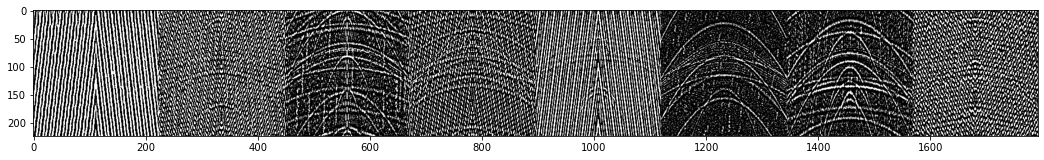

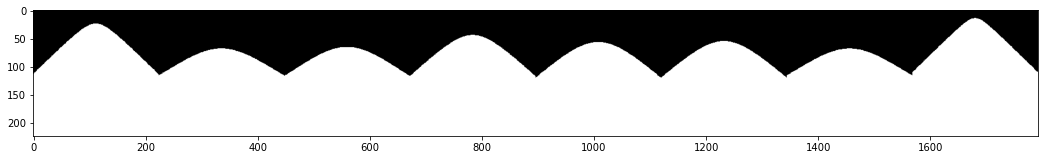

In [22]:
# Examine training data
%pylab inline
import torchvision
sample = iter(train_loader).next()
figure(figsize=(18,9))
imshow(torchvision.utils.make_grid(sample['input'], padding=0).permute((1, 2, 0)))

figure(figsize=(18,9))
imshow(torchvision.utils.make_grid(sample['target'].float().unsqueeze(1), padding=0).permute((1, 2, 0)))
#sample['target']

In [11]:
from metrics import Metrics
loss_fn = nn.CrossEntropyLoss()

epochs = 15
learning_rate = 5e-5

run_id = prefix + 'with_noise_model_{}_problem_{}_gpu_n{}_bs{}_lr{}_pretrained'.format(model_type, problem, epochs, batch_size, learning_rate); print('\n\nTraining', run_id)
save_path = os.path.join(METADATA, run_id + '.pkl')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

metrics = Metrics(2, train_loader.dataset.dataset.class_names)



Training with_noise_model_unet_problem_denoise_gpu_n15_bs8_lr5e-05_pretrained


NameError: name 'METADATA' is not defined

In [24]:
# Used to keep track of statistics
class AverageMeter(object):
    def __init__(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

REPORTS_PER_EPOCH = 10
ITER_PER_EPOCH = len(train_loader)
ITER_PER_REPORT = ITER_PER_EPOCH//REPORTS_PER_EPOCH


for epoch in range(epochs):
    model.train()

    # Progress reporting
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)
    end = time.time()

    for i, (sample) in enumerate(train_loader):

        # Load a batch and send it to GPU
        x = sample['input'].cuda()
        y = sample['target'].cuda()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)

        # Record loss
        losses.update(loss.data.item(), x.size(0))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log training progress
        if i % ITER_PER_REPORT == 0:
            print('\nEpoch: [{0}][{1}/{2}]\t' 'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t' 'ETA {eta}\t'
             'Training Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))
        elif i % (ITER_PER_REPORT) == 0:
            print('.', end='')

        #break # useful for quick debugging
    torch.cuda.empty_cache(); del x, y;

    # Validation after each epoch
    model.eval()
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['input'].float().cuda(), sample['target'].numpy()
        with torch.no_grad():
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction

        metrics.add_batch(y, y_pred.detach().cpu().numpy())
        print('_', end='')
    print('\nValidation stats ', metrics.get_table())


# Save model
save_path = os.path.join(METADATA, run_id + '.pkl')
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))



Training large_noisewith_noise_model_unet_problem_firstbreak_gpu_n15_bs8_lr5e-05_pretrained

Epoch: [0][0/239]	Time 3.388 (3.388)	ETA 0:13:29	Training Loss 0.7005 (0.7005)

Epoch: [0][23/239]	Time 0.094 (18.827)	ETA 0:00:20	Training Loss 0.6748 (0.6929)

Epoch: [0][46/239]	Time 0.094 (36.812)	ETA 0:00:18	Training Loss 0.6100 (0.6692)

Epoch: [0][69/239]	Time 0.132 (54.587)	ETA 0:00:22	Training Loss 0.5752 (0.6432)

Epoch: [0][92/239]	Time 2.663 (72.497)	ETA 0:06:31	Training Loss 0.5528 (0.6242)

Epoch: [0][115/239]	Time 0.093 (87.670)	ETA 0:00:11	Training Loss 0.5420 (0.6095)

Epoch: [0][138/239]	Time 0.096 (105.092)	ETA 0:00:09	Training Loss 0.5326 (0.5982)

Epoch: [0][161/239]	Time 0.129 (119.645)	ETA 0:00:10	Training Loss 0.5253 (0.5891)

Epoch: [0][184/239]	Time 2.577 (135.204)	ETA 0:02:21	Training Loss 0.5286 (0.5817)

Epoch: [0][207/239]	Time 0.093 (150.340)	ETA 0:00:02	Training Loss 0.5261 (0.5753)

Epoch: [0][230/239]	Time 0.093 (167.982)	ETA 0:00:00	Training Loss 0.5122 (0.5


Epoch: [6][230/239]	Time 0.120 (175.486)	ETA 0:00:01	Training Loss 0.3997 (0.3994)
___________________________
Validation stats                  IoU       F1    Prec  recall     Acc
empty       0.98030  0.99000  0.9835  0.9967  0.9938
wave        0.99100  0.99550  0.9985  0.9925  0.9938
total       0.98565  0.99275  0.9910  0.9946  0.9938
total(-bg)  0.99100  0.99550  0.9985  0.9925  0.9938

Epoch: [7][0/239]	Time 2.822 (2.822)	ETA 0:11:14	Training Loss 0.3925 (0.3925)

Epoch: [7][23/239]	Time 0.092 (15.369)	ETA 0:00:19	Training Loss 0.3931 (0.3925)

Epoch: [7][46/239]	Time 0.104 (29.904)	ETA 0:00:20	Training Loss 0.3937 (0.3919)

Epoch: [7][69/239]	Time 0.133 (44.086)	ETA 0:00:22	Training Loss 0.3975 (0.3914)

Epoch: [7][92/239]	Time 1.949 (58.773)	ETA 0:04:46	Training Loss 0.3859 (0.3908)

Epoch: [7][115/239]	Time 0.091 (71.246)	ETA 0:00:11	Training Loss 0.3857 (0.3904)

Epoch: [7][138/239]	Time 0.100 (85.866)	ETA 0:00:10	Training Loss 0.3868 (0.3899)

Epoch: [7][161/239]	Time 0.130


Epoch: [13][138/239]	Time 0.092 (101.505)	ETA 0:00:09	Training Loss 0.3528 (0.3481)

Epoch: [13][161/239]	Time 0.103 (119.317)	ETA 0:00:08	Training Loss 0.3428 (0.3479)

Epoch: [13][184/239]	Time 0.131 (137.428)	ETA 0:00:07	Training Loss 0.3454 (0.3476)

Epoch: [13][207/239]	Time 2.592 (155.505)	ETA 0:01:22	Training Loss 0.3481 (0.3474)

Epoch: [13][230/239]	Time 0.094 (167.848)	ETA 0:00:00	Training Loss 0.3466 (0.3472)
___________________________
Validation stats                  IoU      F1    Prec   recall     Acc
empty       0.99110  0.9955  0.9960  0.99510  0.9972
wave        0.99600  0.9979  0.9978  0.99820  0.9972
total       0.99355  0.9967  0.9969  0.99665  0.9972
total(-bg)  0.99600  0.9979  0.9978  0.99820  0.9972

Epoch: [14][0/239]	Time 2.505 (2.505)	ETA 0:09:58	Training Loss 0.3488 (0.3488)

Epoch: [14][23/239]	Time 0.095 (18.124)	ETA 0:00:20	Training Loss 0.3442 (0.3460)

Epoch: [14][46/239]	Time 0.126 (36.105)	ETA 0:00:24	Training Loss 0.3430 (0.3449)

Epoch: [14][69/2

In [25]:
save_path = os.path.join(METADATA, run_id + '.pkl')
torch.save(model.state_dict(), save_path)

In [15]:
save_file = "model_gpu_n30_bs8_lr5e-05_pretrained.pkl"
save_path = os.path.join(METADATA, run_id + '.pkl')
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

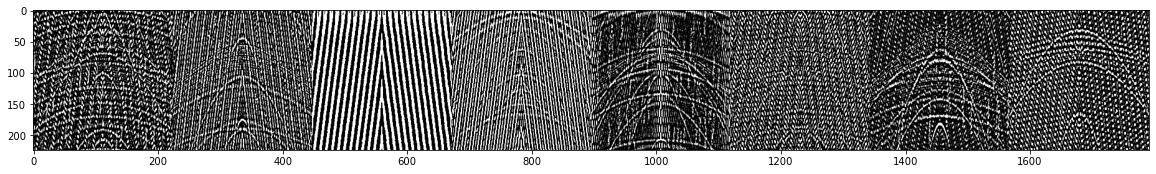

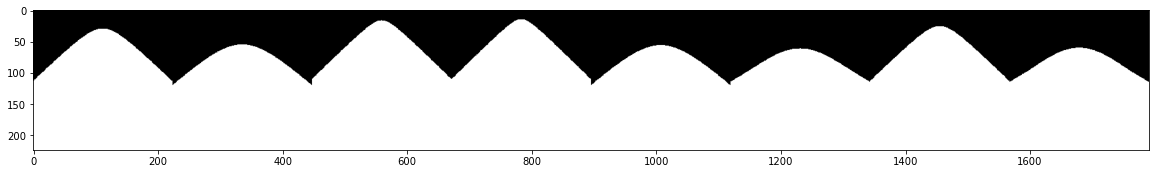

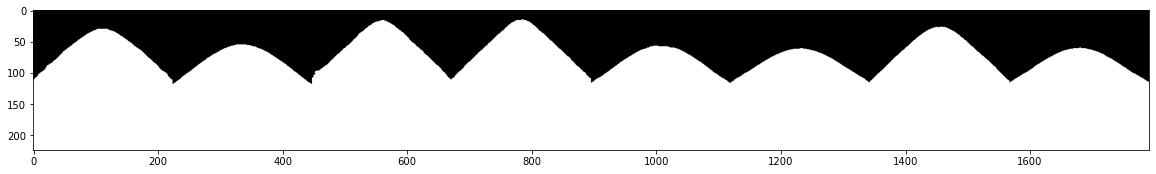

In [27]:
model.eval() # set to evaluation mode

# Visualize validation sample
sample = iter(valid_loader).next()
x = sample['input'].cuda()
y_pred, y = model(x), sample['target']

figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['input'], padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['target'].float().unsqueeze(1), padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(y_pred.argmax(dim=1).detach().cpu().float().unsqueeze(1), padding=0).permute((1, 2, 0)))

In [12]:
data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=workers)
sample = iter(data_loader).next()

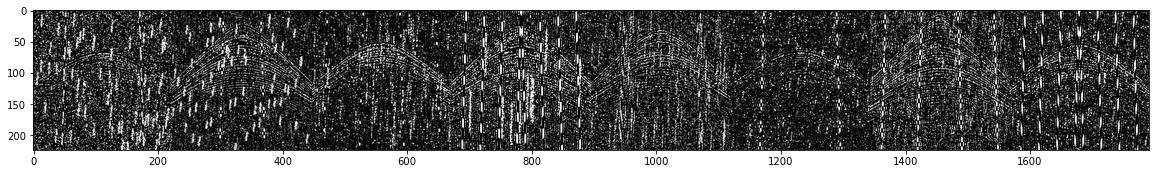

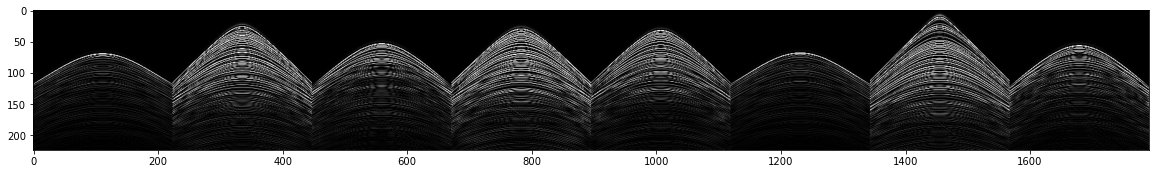

In [26]:
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['input'], padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['target'].float().unsqueeze(1), padding=0).permute((1, 2, 0)))

In [84]:
tb = SummaryWriter('/home/makam0a/tensorboard/denoising/test/')

In [85]:
model.eval() # set to evaluation mode

# Visualize validation sample
sample = iter(valid_loader).next()
x = sample['input'].cuda()
y_pred, y = model(x), sample['target']

In [86]:
input_ = torchvision.utils.make_grid(sample['input'], padding=0)
target_ = torchvision.utils.make_grid(sample['target'].float(), padding=0)
tb.add_image("inputs", input_)
tb.add_image("targets", target_)
tb.add_graph(model, sample['input'].cuda())
tb.close()

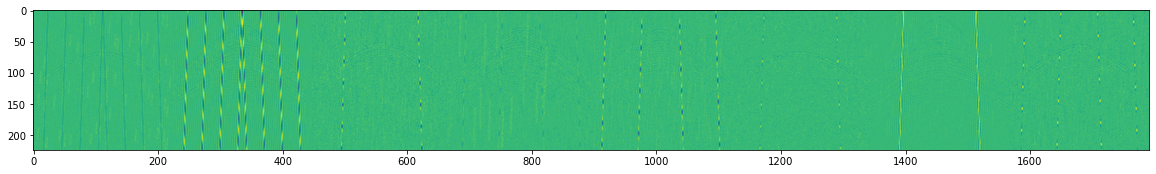

In [89]:
figure(figsize=(20,20)); imshow(input_[0][None,...].permute((1, 2, 0)))

In [75]:
torchvision.utils.make_grid?

In [55]:
torchvision.utils.make_grid?